In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pmdarima as pm
from numpy.random import seed
from scipy import stats
import statsmodels.api as sm

In [2]:
# Batman

In [3]:
Batma = pd.read_csv("Batman_Final.csv")
Batma = Batma[['Date', 'Units_Sold', 'Movie_Playing']]
Batma.head()

,Date,Units_Sold,Movie_Playing
0,1997-04,59706,0
1,1997-04,55389,0
2,1997-05,58451,0
3,1997-06,57641,1
4,1997-06,53416,1


In [4]:
Batma['Date'] = pd.to_datetime(Batma['Date'])

In [5]:
Batma.dtypes

Date             datetime64[ns]
Units_Sold                int64
Movie_Playing             int64
dtype: object

In [6]:
Batma.set_index('Date', inplace=True)
Batma.head()

,Units_Sold,Movie_Playing
Date,,
1997-04-01,59706,0
1997-04-01,55389,0
1997-05-01,58451,0
1997-06-01,57641,1
1997-06-01,53416,1


In [7]:
Batma.index

DatetimeIndex(['1997-04-01', '1997-04-01', '1997-05-01', '1997-06-01',
               '1997-06-01', '1997-07-01', '1997-07-01', '1997-08-01',
               '1997-08-01', '1997-09-01',
               ...
               '2019-10-01', '2019-10-01', '2019-10-01', '2019-11-01',
               '2019-11-01', '2019-11-01', '2019-11-01', '2019-12-01',
               '2019-12-01', '2019-12-01'],
              dtype='datetime64[ns]', name='Date', length=618, freq=None)

In [8]:
Batman = Batma.resample('M').mean()
Batman.head()

,Units_Sold,Movie_Playing
Date,,
1997-04-30,57547.5,0.0
1997-05-31,58451.0,0.0
1997-06-30,55528.5,1.0
1997-07-31,53643.0,1.0
1997-08-31,55042.0,1.0


In [9]:
Batman.isnull().values.any()

True

In [10]:
Batman.isnull().sum().sum()

10

In [11]:
is_NaN = Batman.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = Batman[row_has_NaN]
print(rows_with_NaN)

            Units_Sold  Movie_Playing
Date                                 
2009-03-31         NaN            NaN
2009-05-31         NaN            NaN
2013-09-30         NaN            NaN
2014-09-30         NaN            NaN
2015-05-31         NaN            NaN


In [12]:
Batman = Batman.fillna(method='ffill')

In [13]:
Batman.isnull().values.any()

False

In [14]:
#Statistics

In [15]:
np.random.seed(47)
N_rep = 10000
#Create function to run bootstrap sampling from
def bootstrap(data, func, N_rep):
    #Create empty array 
    bootstrap_rep = np.empty(N_rep)
    #Run bootstrap replicates
    for i in range(N_rep):
        bootstrap_sample = np.random.choice(data, len(data))
        bootstrap_rep[i] = func(bootstrap_sample)
    return bootstrap_rep

In [16]:
#Assign movie and no-movie array
movie = np.array(Batman[Batman['Movie_Playing']==1].Units_Sold)
no_movie = np.array(Batman[Batman['Movie_Playing']==0].Units_Sold)
#Find difference in mean between them
difference_mean = np.mean(movie) - np.mean(no_movie)
difference_mean

4137.306027281607

In [17]:
#Difference of 10000 replicates
bootstrap_mean = bootstrap(movie, np.mean, N_rep) - bootstrap(no_movie, np.mean, N_rep)
#95% confidence interval
conf_interval = np.percentile(bootstrap_mean,[2.5, 97.5])
conf_interval

array([-5103.1632032 , 13811.59009003])

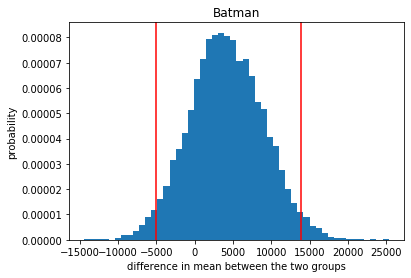

In [18]:
plt.hist(bootstrap_mean, bins=50, density=True)
plt.axvline(conf_interval[0], color='red')
plt.axvline(conf_interval[1], color='red')
plt.title("Batman")
plt.xlabel('difference in mean between the two groups')
plt.ylabel('probability')
plt.savefig('Batman_Stat.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# P Value

In [20]:
stats.ttest_ind(movie, no_movie, equal_var = False)

Ttest_indResult(statistic=0.8449223894705583, pvalue=0.4033637001355216)

In [21]:
# Linear Regression

In [22]:
#Without Movie_Playing External Predictor

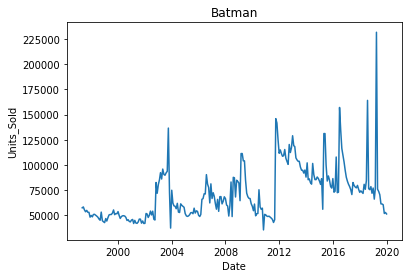

In [23]:
plt.title("Batman")
sns.lineplot(x=Batman.index, y=Batman.Units_Sold, data=Batman)
plt.savefig('Batman_Line.png', dpi=300, bbox_inches='tight')

In [24]:
train = Batman.loc['1997-04-30':'2015-01-31']
test= Batman.loc['2015-02-28':]

In [25]:
train.head()

,Units_Sold,Movie_Playing
Date,,
1997-04-30,57547.5,0.0
1997-05-31,58451.0,0.0
1997-06-30,55528.5,1.0
1997-07-31,53643.0,1.0
1997-08-31,55042.0,1.0


In [26]:
test.head()

,Units_Sold,Movie_Playing
Date,,
2015-02-28,86402.0,0.0
2015-03-31,56126.0,0.0
2015-04-30,131128.0,0.0
2015-05-31,131128.0,0.0
2015-06-30,99901.5,0.0


In [27]:
test_no_movie = Batman[['Units_Sold']]
test_no_movie = test_no_movie.loc['2015-02-28':]
train_no_movie = Batman[['Units_Sold']]
train_no_movie = train_no_movie.loc['1997-04-30':'2015-01-31']

In [28]:
train.shape

(214, 2)

In [29]:
test.shape

(59, 2)

In [30]:
#Find p, d, and q values to build ARIMA model
#P is the order of the Auto Regressive (AR) term or the number of lags of Y to be used as predictors
#D is the number of differencing required to make the time series stationary
#Q is the order of the Moving Average (MA) term or the number of lagged forecast errors that should go into the ARIMA model

In [31]:
#ARIMA

In [32]:
#Auto ARIMA Forecast to choose best p,d,q
model_train_arima = pm.auto_arima(train[['Units_Sold']], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True)

print(model_train_arima.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=4641.073, BIC=4654.537, Time=0.036 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=4922.250, BIC=4928.982, Time=0.007 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=4648.059, BIC=4658.157, Time=0.021 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=4777.475, BIC=4787.573, Time=0.102 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=5395.535, BIC=5398.901, Time=0.007 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=4642.461, BIC=4659.291, Time=0.085 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=4641.137, BIC=4657.967, Time=0.053 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=4795.355, BIC=4808.819, Time=0.050 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=4643.220, BIC=4656.684, Time=0.050 seconds
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=4640.328, BIC=4660.524, Time=0.138 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercep

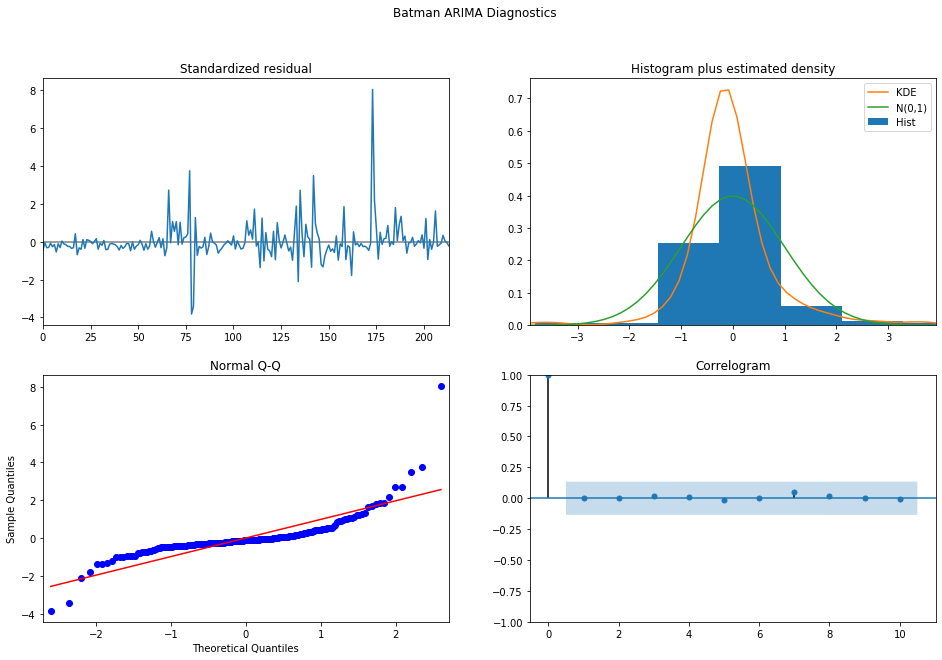

In [33]:
model_train_arima.plot_diagnostics(figsize=(16,10))
plt.suptitle("Batman ARIMA Diagnostics")
plt.savefig('Batman_Diag_ARIMA.png', dpi=300, bbox_inches='tight')
plt.show()

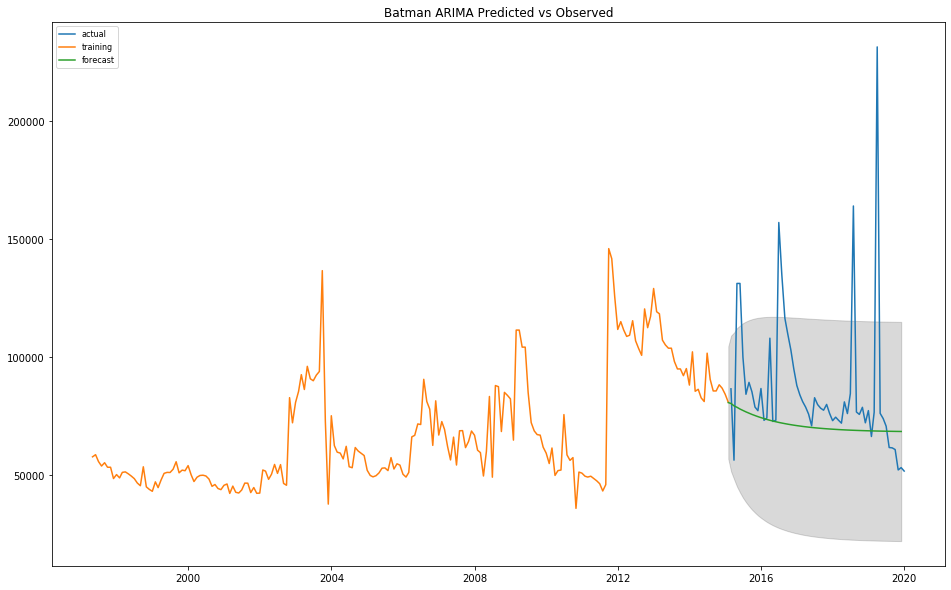

In [34]:
# Forecast
n_periods_arima = 59
fc_arima, confint_arima = model_train_arima.predict(n_periods=n_periods_arima, return_conf_int=True)
index_of_fc_arima = pd.date_range(train.index[-1], periods = n_periods_arima, freq='MS')

# make series for plotting purpose
fc_series_arima = pd.Series(fc_arima, index=index_of_fc_arima)
lower_series_arima = pd.Series(confint_arima[:, 0], index=index_of_fc_arima)
upper_series_arima = pd.Series(confint_arima[:, 1], index=index_of_fc_arima)

# Plot
plt.figure(figsize=(16,10))
plt.plot(test_no_movie, label='actual')
plt.plot(train_no_movie, label='training')
plt.plot(fc_series_arima, label='forecast')
plt.fill_between(lower_series_arima.index, lower_series_arima, upper_series_arima, color='k', alpha=.15)
plt.title("Batman ARIMA Predicted vs Observed")
plt.legend(loc='upper left', fontsize=8)
plt.savefig('Batman_Predict_ARIMA.png', dpi=300, bbox_inches='tight')
plt.show()

In [35]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [36]:
mean_absolute_percentage_error(test_no_movie, fc_series_arima)

18.044019512739872

In [37]:
#SARIMA

In [38]:
#Auto SARIMA Forecast to choose best p,d,q
model_train_sarima = pm.auto_arima(train[['Units_Sold']], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True)

print(model_train_sarima.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=4429.152, BIC=4445.669, Time=2.405 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=4517.239, BIC=4523.846, Time=0.039 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=4475.276, BIC=4488.489, Time=0.416 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=4402.261, BIC=4415.474, Time=2.314 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=4515.646, BIC=4518.949, Time=0.028 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=4509.404, BIC=4522.618, Time=0.317 seconds
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=4437.524, BIC=4457.344, Time=1.101 seconds
Fit ARIMA(1,1,1)x(0,1,2,12) [intercept=True]; AIC=4437.520, BIC=4457.340, Time=3.805 seconds
Fit ARIMA(1,1,1)x(1,1,0,12) [intercept=True]; AIC=447

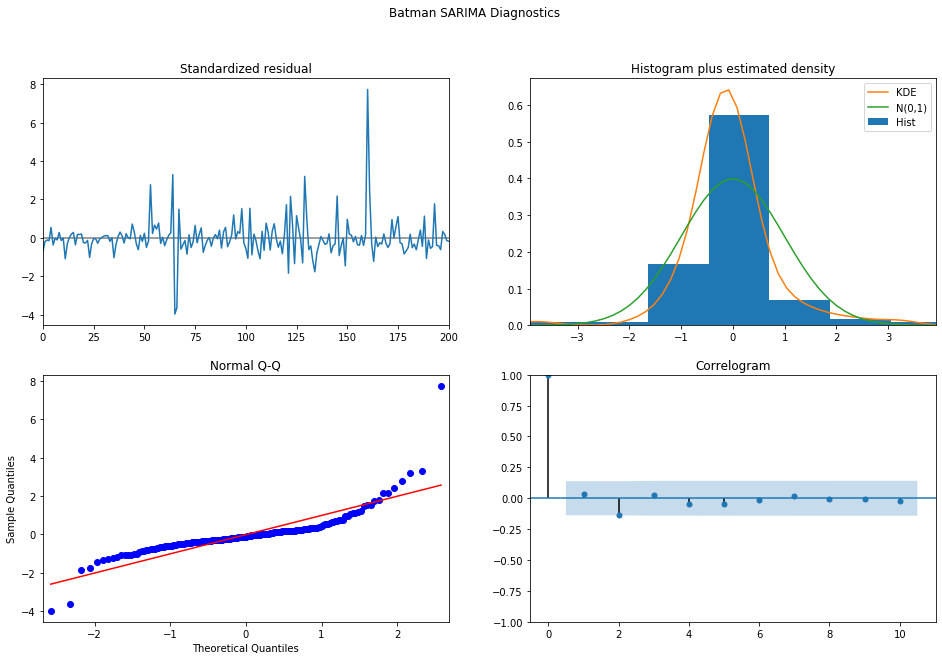

In [39]:
model_train_sarima.plot_diagnostics(figsize=(16,10))
plt.suptitle("Batman SARIMA Diagnostics")
plt.savefig('Batman_Diag_SARIMA.png', dpi=300, bbox_inches='tight')
plt.show()

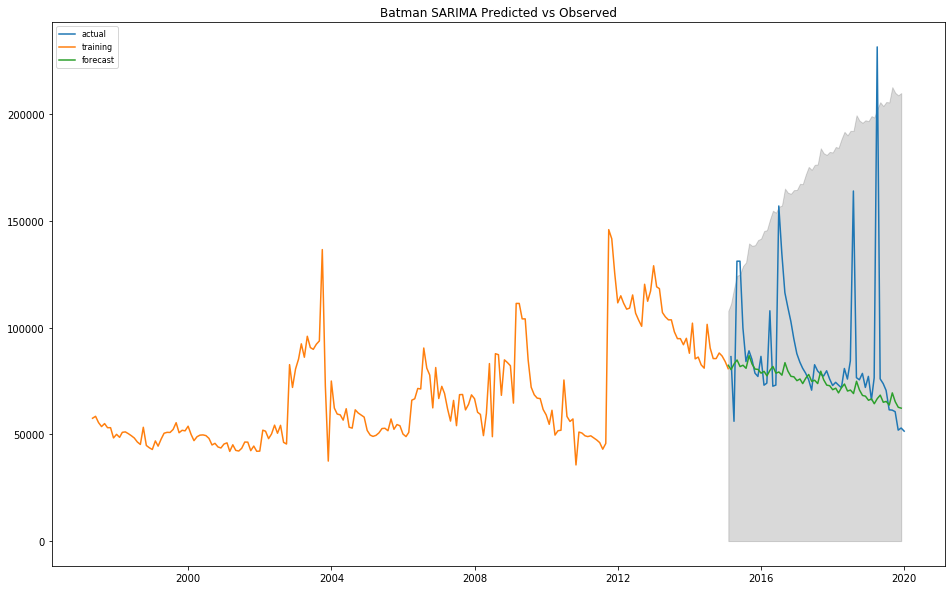

In [40]:
# Forecast
n_periods_sarima = 59
fc_sarima, confint_sarima = model_train_sarima.predict(n_periods=n_periods_sarima, return_conf_int=True)
index_of_fc_sarima = pd.date_range(train.index[-1], periods = n_periods_sarima, freq='MS')

# make series for plotting purpose
fc_series_sarima = pd.Series(fc_sarima, index=index_of_fc_sarima)
lower_series_sarima = pd.Series(confint_sarima[:, 0], index=index_of_fc_sarima)
upper_series_sarima = pd.Series(confint_sarima[:, 1], index=index_of_fc_sarima)

# Plot
plt.figure(figsize=(16,10))
plt.plot(test_no_movie, label='actual')
plt.plot(train_no_movie, label='training')
plt.plot(fc_series_sarima, label='forecast')
plt.fill_between(upper_series_sarima.index, upper_series_sarima, color='k', alpha=.15)
plt.title("Batman SARIMA Predicted vs Observed")
plt.legend(loc='upper left', fontsize=8)
plt.savefig('Batman_Predict_SARIMA.png', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
mean_absolute_percentage_error(test_no_movie, fc_series_sarima)

18.05778667442135

In [42]:
# With Movie_Playing External Predictor

In [43]:
#SARIMAX

In [44]:
#Auto SARIMAX Forecast to choose best p,d,q
model_train_sarimax = pm.auto_arima(train[['Units_Sold']], exogenous=train[['Movie_Playing']], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True)

print(model_train_sarimax.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,12) [intercept=True]; AIC=4448.045, BIC=4467.894, Time=1.304 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=4698.680, BIC=4708.605, Time=0.067 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=4487.418, BIC=4503.959, Time=1.016 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=4553.050, BIC=4569.592, Time=0.914 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=5569.256, BIC=5575.872, Time=0.059 seconds
Fit ARIMA(1,0,1)x(0,1,0,12) [intercept=True]; AIC=4525.359, BIC=4541.900, Time=0.241 seconds
Fit ARIMA(1,0,1)x(1,1,1,12) [intercept=True]; AIC=4450.039, BIC=4473.196, Time=1.853 seconds
Fit ARIMA(1,0,1)x(0,1,2,12) [intercept=True]; AIC=4450.008, BIC=4473.166, Time=7.494 seconds
Fit ARIMA(1,0,1)x(1,1,0,12) [intercept=True]; AIC=4487.787, BIC=4507.637, Time=1.049 seconds
Fit ARIMA(1,0,1)x(1,1,2,12) [intercept=True]; AIC=4451.439, BIC=4477.906, Time=14.436 seconds
Fit ARIMA(1,0,0)x(0,1,1,1

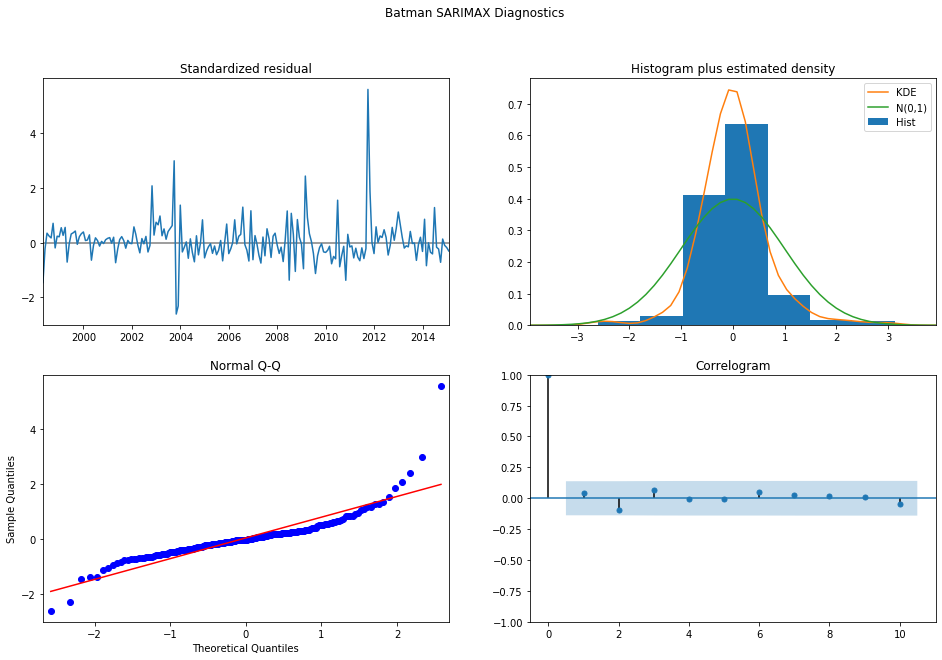

In [45]:
model_train_sarimax.plot_diagnostics(figsize=(16,10))
plt.suptitle("Batman SARIMAX Diagnostics")
plt.savefig('Batman_Diag_SARIMAX.png', dpi=300, bbox_inches='tight')
plt.show()

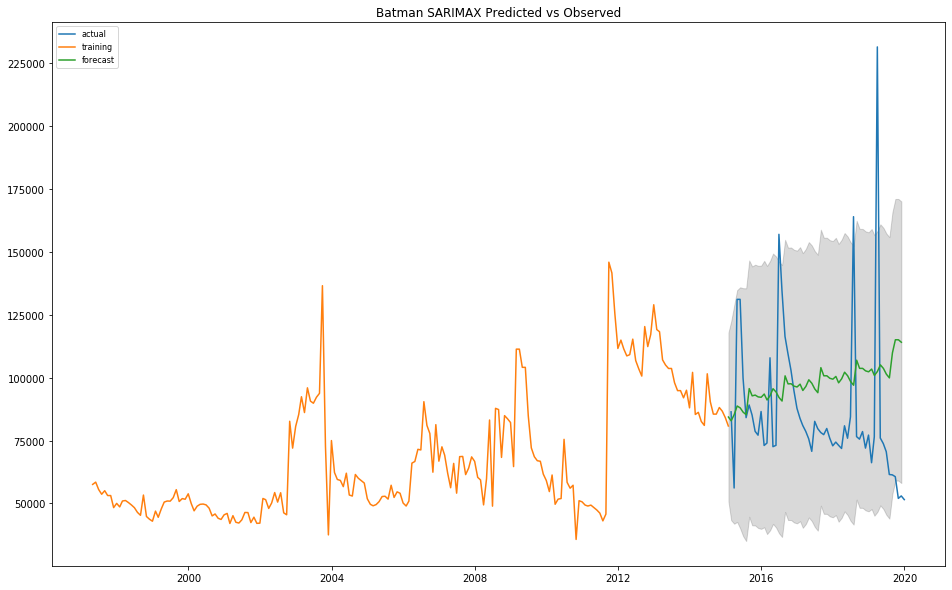

In [46]:
# Forecast
n_periods_sarimax = 59
fc_sarimax, confint_sarimax = model_train_sarimax.predict(n_periods=n_periods_sarimax, exogenous=test[['Movie_Playing']], 
                                                          return_conf_int=True)
index_of_fc_sarimax = pd.date_range(train.index[-1], periods = n_periods_sarimax, freq='MS')

# make series for plotting purpose
fc_series_sarimax = pd.Series(fc_sarimax, index=index_of_fc_sarimax)
lower_series_sarimax = pd.Series(confint_sarimax[:, 0], index=index_of_fc_sarimax)
upper_series_sarimax = pd.Series(confint_sarimax[:, 1], index=index_of_fc_sarimax)

# Plot
plt.figure(figsize=(16,10))
plt.plot(test[['Units_Sold']], label='actual')
plt.plot(train[['Units_Sold']], label='training')
plt.plot(fc_series_sarimax, label='forecast')
plt.fill_between(lower_series_sarimax.index, lower_series_sarimax, upper_series_sarimax, color='k', alpha=.15)
plt.title("Batman SARIMAX Predicted vs Observed")
plt.legend(loc='upper left', fontsize=8)
plt.savefig('Batman_Predict_SARIMAX.png', dpi=300, bbox_inches='tight')
plt.show()

In [47]:
mean_absolute_percentage_error(test_no_movie, fc_series_sarimax)

31.34217373198942